# Practice notebook for confidence intervals using NHANES data

This notebook will give you the opportunity to practice working with confidence intervals using the NHANES data.

You can enter your code into the cells that say "enter your code here", and you can type responses to the questions into the cells that say "Type Markdown and Latex".

Note that most of the code that you will need to write below is very similar to code that appears in the case study notebook.  You will need to edit code from that notebook in small ways to adapt it to the prompts below.

To get started, we will use the same module imports and read the data in the same way as we did in the case study:

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

da = pd.read_csv("nhanes_2015_2016.csv")

## Question 1

Restrict the sample to women between 35 and 50, then use the marital status variable [DMDMARTL](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#DMDMARTL) to partition this sample into two groups - women who are currently married, and women who are not currently married.  Within each of these groups, calculate the proportion of women who have completed college.  Calculate 95% confidence intervals for each of these proportions.

In [37]:
da.columns

Index(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'RIAGENDR', 'RIDAGEYR',
       'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'WTINT2YR',
       'SDMVPSU', 'SDMVSTRA', 'INDFMPIR', 'BPXSY1', 'BPXDI1', 'BPXSY2',
       'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC',
       'BMXWAIST', 'HIQ210'],
      dtype='object')

In [38]:
da["DMDMARTL"].value_counts()

1.0     2780
5.0     1004
3.0      579
6.0      527
2.0      396
4.0      186
77.0       2
Name: DMDMARTL, dtype: int64

In [39]:
da["DMDEDUC2"].value_counts()

4.0    1621
5.0    1366
3.0    1186
1.0     655
2.0     643
9.0       3
Name: DMDEDUC2, dtype: int64

In [40]:
da["RIAGENDRx"] = da["RIAGENDR"].replace({1:"Male",2:"Female"})
da["DMDMARTLx"] = da["DMDMARTL"].replace({1:"Married", 2: "Not_Married", 3: "Not_Married", 
                                           4: "Not_Married", 5: "Not_Married", 
                                           6: "Not_Married", 77: np.nan})
da["DMDEDUC2x"] = da["DMDEDUC2"].replace({1: "Not_College",2: "Not_College",3: "Not_College",
                                         4: "Not_College", 5: "College", 9: np.nan})
cond1 = da.RIAGENDRx == "Female"
cond2 = da.RIDAGEYR.between(35,50)
dx = da.loc[cond1&cond2, ["RIAGENDRx","RIDAGEYR","DMDMARTLx","DMDEDUC2x"]]
dx.head()

,RIAGENDRx,RIDAGEYR,DMDMARTLx,DMDEDUC2x
4,Female,42,Not_Married,Not_College
34,Female,37,Married,Not_College
50,Female,39,Married,Not_College
52,Female,50,Not_Married,Not_College
55,Female,45,Married,Not_College


In [41]:
dx1 = dx.groupby("DMDMARTLx").agg({"DMDEDUC2x": [lambda x: np.mean(x== "College"), np.size]})
dx1.columns = ["Prop", "Size"]
dx1

,Prop,Size
DMDMARTLx,,
Married,0.360802,449
Not_Married,0.213018,338


In [42]:
p = dx1.Prop.Married
n = dx1.Size.Married
lcb_Married = p - 1.96* np.sqrt((1-p)*p/n)
ucb_Married = p + 1.96* np.sqrt((1-p)*p/n)
(lcb_Married, ucb_Married)

(0.3163811208674688, 0.4052224426069187)

In [43]:
p = dx1.Prop.Not_Married
n = dx1.Size.Not_Married
lcb_Not_Married = p - 1.96* np.sqrt((1-p)*p/n)
ucb_Not_Married = p + 1.96* np.sqrt((1-p)*p/n)
(lcb_Not_Married, ucb_Not_Married)

(0.1693673655848136, 0.25666813737376626)

In [44]:
dx2 = pd.crosstab(dx.DMDMARTLx, dx.DMDEDUC2x)
dx2["Total"] = dx2.College + dx2.Not_College
dx2

DMDEDUC2x,College,Not_College,Total
DMDMARTLx,,,
Married,162,287,449
Not_Married,72,266,338


In [45]:
sm.stats.proportion_confint(dx2.College.Married, dx2.Total.Married)

(0.31638193710753626, 0.4052216263668512)

In [46]:
sm.stats.proportion_confint(dx2.College.Not_Married, dx2.Total.Not_Married)

(0.16936816767089768, 0.2566673352876822)

In [47]:
compare = np.asarray(sm.stats.proportion_confint(dx2.College, dx2.Total))
diff = compare[1]-compare[0]
diff

array([0.08883969, 0.08729917])

__Q1a.__ Identify which of the two confidence intervals is wider, and explain why this is the case. 

Married is wider than non-Married



__Q1b.__ Write 1-2 sentences summarizing these findings for an audience that does not know what a confidence interval is (the goal here is to report the substance of what you learned about how marital status and educational attainment are related, not to teach a person what a confidence interval is).

NA

## Question 2

Construct a 95% confidence interval for the proportion of smokers who are female. Construct a 95% confidence interval for the proportion of smokers who are male. Construct a 95% confidence interval for the **difference** between those two gender proportions.

In [52]:
da["SMQ020x"] = da["SMQ020"].replace({1:"Yes",2:"No", 7:np.nan, 9:np.nan})
da1 = da[['RIAGENDRx','SMQ020x']].dropna()
ds = da1.groupby("RIAGENDRx").agg({"SMQ020x": [lambda x: np.mean(x == "Yes"), np.size]})
ds.columns = ["prop","n"]
ds

,prop,n
RIAGENDRx,,
Female,0.304845,2972
Male,0.513258,2753


In [59]:
pf= ds.prop.Female
nf= ds.n.Female
lcbf = pf - 1.96 * np.sqrt(pf*(1-pf)/n)
ucbf = pf + 1.96 * np.sqrt(pf*(1-pf)/n)
print(pf, nf, lcbf, ucbf)

pm= ds.prop.Male
nm= ds.n.Male
lcbm = pm - 1.96 * np.sqrt((1-pm)*pm/n)
ucbm = pm + 1.96 * np.sqrt((1-pm)*pm/n)
print(pm, nm, lcbm, ucbm)

0.30484522207267833 2972 0.288294683866098 0.32139576027925865
0.5132582637123139 2753 0.4952882281104308 0.5312282993141969


In [61]:
ds1 = pd.crosstab(da1.RIAGENDRx, da1.SMQ020x)
ds1.columns = ["Non_Smoker","Smoker"]
ds1['Total'] =  ds1.Non_Smoker + ds1.Smoker
print(ds1)
ds1f = sm.stats.proportion_confint(906, 2972)
ds1m = sm.stats.proportion_confint(1413, 2753)
print(ds1f)
print(ds1m)

           Non_Smoker  Smoker  Total
RIAGENDRx                           
Female           2066     906   2972
Male             1340    1413   2753
(0.2882949879861214, 0.32139545615923526)
(0.49458749263718593, 0.5319290347874418)


__Q2a.__ Why might it be relevant to report the separate gender proportions **and** the difference between the gender proportions?

NA

__Q2b.__ How does the **width** of the confidence interval for the difference between the gender proportions compare to the widths of the confidence intervals for the separate gender proportions?

In [74]:
ds1all =sm.stats.proportion_confint(906+1413, 2972+2753)
ds1compare = [ds1f, ds1m, ds1all]
ds1compare = np.asarray(ds1compare)
print(ds1compare)
ds1compare[:,1]-ds1compare[:,0]

[[0.28829499 0.32139546]
 [0.49458749 0.53192903]
 [0.3923493  0.41778171]]


array([0.03310047, 0.03734154, 0.02543241])

## Question 3

Construct a 95% interval for height ([BMXHT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXHT)) in centimeters.  Then convert height from centimeters to inches by dividing by 2.54, and construct a 95% confidence interval for height in inches.  Finally, convert the endpoints (the lower and upper confidence limits) of the confidence interval from inches to back to centimeters   

In [79]:
da["BMXHTx"] = da.BMXHT/2.54
dh = da[['BMXHTx']].dropna()
sm.stats.DescrStatsW(dh).zconfint_mean()

(array([65.30730365]), array([65.51382587]))

In [87]:
dh.describe()

,BMXHTx
count,5673.000000
mean,65.410565
std,3.968214
min,51.062992
25%,62.480315
50%,65.354331
75%,68.307087
max,79.803150


In [89]:
mh = dh.mean()
nh = dh.count()
stdh = dh.std()
lcbh = mh - 1.96 * stdh/np.sqrt(nh)
ucbh = mh + 1.96 * stdh/np.sqrt(nh)
(lcbh, ucbh)

(BMXHTx    65.307302
 dtype: float64, BMXHTx    65.513828
 dtype: float64)

In [90]:
dh1 = da[['BMXHT']].dropna()
sm.stats.DescrStatsW(dh1).zconfint_mean()

(array([165.88055126]), array([166.4051177]))

In [93]:
np.asarray(sm.stats.DescrStatsW(dh1).zconfint_mean())/2.54

array([[65.30730365],
       [65.51382587]])

__Q3a.__ Describe how the confidence interval constructed in centimeters relates to the confidence interval constructed in inches.

same

## Question 4

Partition the sample based on 10-year age bands, i.e. the resulting groups will consist of people with ages from 18-28, 29-38, etc. Construct 95% confidence intervals for the difference between the mean BMI for females and for males within each age band.

In [178]:
da["agegrp"] = pd.cut(da.RIDAGEYR, [18,28,38,48,58,68,80])
da["agegrp"].value_counts()

(68, 80]    964
(28, 38]    961
(18, 28]    956
(58, 68]    936
(38, 48]    912
(48, 58]    873
Name: agegrp, dtype: int64

In [179]:
db = da[["RIAGENDRx","agegrp","BMXBMI"]].dropna()
db1 = db.groupby(['agegrp','RIAGENDRx']).agg({"BMXBMI": [np.mean, np.size,np.std]}).unstack()
db1.columns = ["mean_f", "mean_m","size_f","size_m", "std_f", "std_m"]
db1

,mean_f,mean_m,size_f,size_m,std_f,std_m
agegrp,,,,,,
"(18, 28]",28.019433,27.058186,494.0,452.0,8.048854,6.679515
"(28, 38]",29.943443,29.697180,488.0,461.0,7.959097,6.726690
"(38, 48]",31.003733,29.514646,509.0,396.0,8.044642,6.104950
"(48, 58]",30.787361,29.385132,451.0,417.0,7.647590,6.151534
"(58, 68]",31.054664,29.232462,461.0,459.0,7.779502,5.959024
"(68, 80]",29.412685,28.255319,473.0,470.0,6.403343,5.139608


In [180]:
db1["sem_f"] = db1.std_f/np.sqrt(db1.size_f)
db1["sem_m"] = db1.std_m/np.sqrt(db1.size_m)
db1

,mean_f,mean_m,size_f,size_m,std_f,std_m,sem_f,sem_m
agegrp,,,,,,,,
"(18, 28]",28.019433,27.058186,494.0,452.0,8.048854,6.679515,0.362135,0.314178
"(28, 38]",29.943443,29.697180,488.0,461.0,7.959097,6.726690,0.360291,0.313293
"(38, 48]",31.003733,29.514646,509.0,396.0,8.044642,6.104950,0.356572,0.306785
"(48, 58]",30.787361,29.385132,451.0,417.0,7.647590,6.151534,0.360111,0.301242
"(58, 68]",31.054664,29.232462,461.0,459.0,7.779502,5.959024,0.362328,0.278143
"(68, 80]",29.412685,28.255319,473.0,470.0,6.403343,5.139608,0.294426,0.237072


In [181]:
db1['lcb_f'] = db1.mean_f - 1.96 * db1.sem_f
db1['lcb_m'] = db1.mean_m - 1.96 * db1.sem_m
db1['ucb_f'] = db1.mean_f + 1.96 * db1.sem_f
db1['ucb_m'] = db1.mean_m + 1.96 * db1.sem_m
db1['mean_diff'] = db1.mean_f - db1.mean_m
db1['sem_diff'] = np.sqrt(db1.sem_f **2 + db1.sem_m **2)
db1['ci_range_f'] = db1.ucb_f - db1.lcb_f
db1['ci_range_m'] = db1.ucb_m - db1.lcb_m
db1

,mean_f,mean_m,size_f,size_m,std_f,std_m,sem_f,sem_m,lcb_f,lcb_m,ucb_f,ucb_m,mean_diff,sem_diff,ci_range_f,ci_range_m
agegrp,,,,,,,,,,,,,,,,
"(18, 28]",28.019433,27.058186,494.0,452.0,8.048854,6.679515,0.362135,0.314178,27.309649,26.442397,28.729218,27.673975,0.961247,0.479426,1.419569,1.231578
"(28, 38]",29.943443,29.697180,488.0,461.0,7.959097,6.726690,0.360291,0.313293,29.237271,29.083125,30.649614,30.311235,0.246263,0.477454,1.412342,1.228109
"(38, 48]",31.003733,29.514646,509.0,396.0,8.044642,6.104950,0.356572,0.306785,30.304851,28.913347,31.702615,30.115946,1.489086,0.470384,1.397764,1.202598
"(48, 58]",30.787361,29.385132,451.0,417.0,7.647590,6.151534,0.360111,0.301242,30.081544,28.794698,31.493179,29.975566,1.402230,0.469496,1.411635,1.180868
"(58, 68]",31.054664,29.232462,461.0,459.0,7.779502,5.959024,0.362328,0.278143,30.344502,28.687301,31.764826,29.777623,1.822202,0.456777,1.420324,1.090322
"(68, 80]",29.412685,28.255319,473.0,470.0,6.403343,5.139608,0.294426,0.237072,28.835610,27.790657,29.989760,28.719981,1.157366,0.378008,1.154150,0.929324


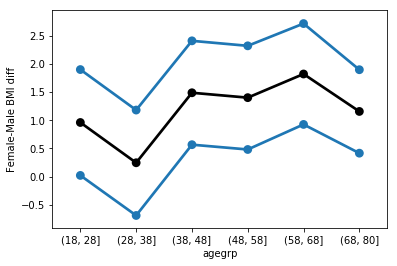

In [182]:
sns.pointplot(db1.index, db1.mean_diff, color = 'black').set_ylabel("Female-Male BMI diff")
sns.pointplot(db1.index, db1.mean_diff - 1.96 * db1.sem_diff)
sns.pointplot(db1.index, db1.mean_diff + 1.96 * db1.sem_diff)

__Q4a.__ How do the widths of these confidence intervals differ?  Provide an explanation for any substantial diferences in the confidence interval widths that you see.

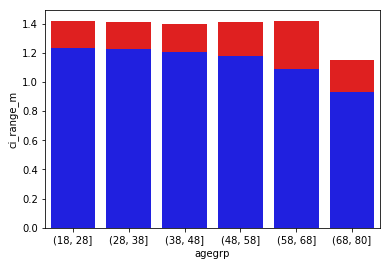

In [183]:
db1[["ci_range_f","ci_range_m"]]
sns.barplot(db1.index, db1.ci_range_f, color = "red")
sns.barplot(db1.index,db1.ci_range_m, color = "blue")

## Question 5

Construct a 95% confidence interval for the first and second systolic blood pressure measures, and for the difference between the first and second systolic blood pressure measurements within a subject.

In [197]:
da.columns

Index(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'RIAGENDR', 'RIDAGEYR',
       'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'WTINT2YR',
       'SDMVPSU', 'SDMVSTRA', 'INDFMPIR', 'BPXSY1', 'BPXDI1', 'BPXSY2',
       'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC',
       'BMXWAIST', 'HIQ210', 'RIAGENDRx', 'DMDMARTLx', 'DMDEDUC2x', 'SMQ020x',
       'BMXHTx', 'agegrp'],
      dtype='object')

In [212]:
dbp = da[['BPXSY1','BPXSY2']].dropna()
dbp1 = {"Type": ["mean","std"], "BPXSY1": [np.mean(dbp.BPXSY1), np.std(dbp.BPXSY1)], 
       "BPXSY2": [np.mean(dbp.BPXSY2), np.std(dbp.BPXSY2)]}
dbp2 = pd.DataFrame(data=dbp1)
dbp2

,Type,BPXSY1,BPXSY2
0,mean,125.088471,124.413485
1,std,18.492079,18.189879


In [213]:
dbp.head()

,BPXSY1,BPXSY2
0,128.0,124.0
1,146.0,140.0
2,138.0,132.0
3,132.0,134.0
4,100.0,114.0


In [216]:
conf_bp1 = sm.stats.DescrStatsW(dbp.BPXSY1).zconfint_mean()
conf_bp2 = sm.stats.DescrStatsW(dbp.BPXSY2).zconfint_mean()
print(conf_bp1)
print(conf_bp2)

(124.59378718804363, 125.5831545143218)
(123.92688534371334, 124.90008429681563)


__Q5a.__ Based on these confidence intervals, would you say that a difference of zero between the population mean values of the first and second systolic blood pressure measures is consistent with the data?

__Q5b.__ Discuss how the width of the confidence interval for the within-subject difference compares to the widths of the confidence intervals for the first and second measures.

## Question 6

Construct a 95% confidence interval for the mean difference between the average age of a smoker, and the average age of a non-smoker.

In [189]:
dsm = da[["RIDAGEYR", "SMQ020x","agegrp"]].dropna()
dsm1= dsm.groupby("SMQ020x").agg({"RIDAGEYR":[np.mean, np.size]})
dsm1.columns = [["mean_age","size"]]
dsm1

,mean_age,size
SMQ020x,,
No,46.307012,3280
Yes,52.199827,2312


Avg age of smoker = 52

In [185]:
sm.stats.DescrStatsW(dsm[dsm.SMQ020x == "Yes"].RIDAGEYR).zconfint_mean()

(51.491129434590896, 52.908524544647854)

__Q6a.__ Use graphical and numerical techniques to compare the variation in the ages of smokers to the variation in the ages of non-smokers.  

In [186]:
dsm2= dsm.groupby(["agegrp","SMQ020x"]).agg({"RIDAGEYR":[np.mean, np.var]}).unstack()
dsm2.columns = ["mean_nonsmoker", "mean_smoker", "var_nonsmoker", "var_smoker"]
dsm2

,mean_nonsmoker,mean_smoker,var_nonsmoker,var_smoker
agegrp,,,,
"(18, 28]",23.443491,23.863281,8.980685,7.585156
"(28, 38]",33.316695,33.576720,8.040910,8.313727
"(38, 48]",43.595960,43.650943,7.944402,8.347807
"(48, 58]",53.125786,53.739899,7.820279,7.306860
"(58, 68]",63.282851,63.154639,7.564906,8.560748
"(68, 80]",76.025000,75.350731,15.757203,16.872547


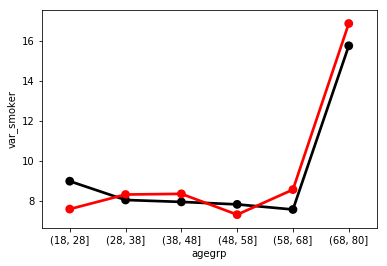

In [187]:
sns.pointplot(dsm2.index, dsm2.var_nonsmoker, color = 'black')
sns.pointplot(dsm2.index, dsm2.var_smoker, color = 'red')

__Q6b.__ Does it appear that uncertainty about the mean age of smokers, or uncertainty about the mean age of non-smokers contributed more to the uncertainty for the mean difference that we are focusing on here?

In [196]:
print(dsm1)

          mean_age  size
SMQ020x                 
No       46.307012  3280
Yes      52.199827  2312


NA